In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import numpy as np

from tqdm import tqdm
from torch.utils.data import DataLoader

from utility import *
from unet import UNet
from autoencoder import Autoencoder, BigAutoencoder
from dataloader import CustomImageDataset, data_to_images, images_to_data

# Demo of the trained Colorization Model

For now just colorizes the images of a video, and stores them as a new video.

## 1. Data Loading

using the pytorch dataloader and dataset implementation from DataLoad.py

In [2]:
# HYPERPARAMETERS
dataset_path = '~/Documents/Colorization/Datasets/DAVIS'
dataset_path = os.path.expanduser(dataset_path)
subdir = 'val'
res = '176p'
method = 'deepflow'
use_flow = True

In [3]:
dataset = CustomImageDataset(dataset_path, subdir, res, method, use_flow)

dataset_size = len(dataset)
print('Dataset size:', dataset_size)

vid labels: ['basketball-game', 'bmx-rider', 'butterfly', 'car-competition', 'cat', 'chairlift', 'circus', 'dog-competition', 'dolphins-show', 'drone-flying', 'ducks', 'giraffes', 'gym-ball', 'helicopter-landing', 'horse-race', 'hurdles-race', 'ice-hockey', 'jet-ski', 'juggling-selfie', 'kids-robot', 'mantaray', 'mascot', 'motorbike-race', 'obstacles', 'plane-exhibition', 'robot-battle', 'snowboard-race', 'swimmer', 'tram', 'trucks-race']
Dataset size: 2264


In [4]:
img1_path = '/Users/Mika/Desktop/10_Semester/3DCV/PROJECT/DAVIS/train/176p/bear/00000.jpg'
img2_path = '/Users/Mika/Desktop/10_Semester/3DCV/PROJECT/DAVIS/train/176p/bear/00081.jpg'
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

psnr = cv2.PSNR(img1, img2)
print(psnr)

nan


[ WARN:0@0.906] global /croot/opencv-suite_1691620365762/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/Users/Mika/Desktop/10_Semester/3DCV/PROJECT/DAVIS/train/176p/bear/00000.jpg'): can't open/read file: check file path/integrity
[ WARN:0@0.906] global /croot/opencv-suite_1691620365762/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/Users/Mika/Desktop/10_Semester/3DCV/PROJECT/DAVIS/train/176p/bear/00081.jpg'): can't open/read file: check file path/integrity


## 2. Model Loading

In [5]:


print("Cuda available: ", torch.cuda.is_available())

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

print("Using device: ", device)

Cuda available:  True
Using device:  cpu


In [59]:
#initialize model
if use_flow:
    n_input_channels = 6
else:
    n_input_channels = 4

model = UNet(n_input_channels=n_input_channels)
model.to(device)

# Hyperparameters
learning_rate = 1e-3
batch_size = 16
epochs = 150

# Initialize the loss function
loss_fn = nn.MSELoss()


# Data loader
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [60]:
model_path = '~/Documents/Colorization/Models/'
UNet_folder = 'UNet'
model_path = os.path.expanduser(model_path)
UNet_folder = os.path.join(model_path, UNet_folder)

In [69]:
model_folder = 'UNet_farneback_75_epochs_1-3_step'

filename = 'UNet_farneback_75.pth'

resume(model, os.path.join(UNet_folder, model_folder),  filename )

## 3. Video Rendering

In [9]:
def colorize_video(images_bw_path, images_col_path, method, use_flow=True, frame_gap=1, architecture='UNet'):
    # Video rendering with multiple frame gap

    print('Colorizing video with frame gap:', frame_gap)
    
    

    video_path = images_bw_path
    still_path = images_col_path
    make_dir(still_path)

    n_frames = len(os.listdir(video_path))
    # print('Number of frames:', n_frames)

    col_img_array = []
    col_img = load_image(os.path.join(images_col_path, '00000.jpg'))
    col_img = resize_image(col_img)
    input_size = (col_img.shape[0], col_img.shape[1])
    col_img_array.append(col_img)

    gray_img = None
    flow_img = None
    i = 1
    while i < n_frames:
        img_path = os.path.join(video_path, str(i).zfill(5)+'.jpg')
        
        gray_img = load_image(img_path)
        gray_img = resize_image(gray_img)

        if use_flow:
            flow_img = dense_optical_flow(col_img_array[0], gray_img, method=method, to_gray=True)

        input, _ = images_to_data(col_img_array[0], flow_img, gray_img)
        
        prediction = model(input.unsqueeze(0).to(device))
        prediction = prediction.cpu()
        prediction = prediction.detach()
        prediction = prediction.squeeze(0)

        _, flow_img, grey_img, pred_img = data_to_images(input, prediction, use_flow=use_flow, input_only=False)


        """
        plt.subplot(1,4,1)
        plt.imshow(uv_2_rgb(flow_img))
        plt.title('Flow')
        plt.subplot(1,4,2)
        plt.imshow(grey_img, cmap='gray')
        plt.title('Gray')
        plt.subplot(1,4,3)
        plt.imshow(pred_img)
        plt.title('Pred')
        plt.subplot(1,4,4)
        plt.imshow(col_img_array[0])
        plt.title('Col')
        plt.show()
        """
        save_image(pred_img, os.path.join(still_path, str(i).zfill(5)+'.jpg'))

        col_img_array.append(pred_img)
        if len(col_img_array) > frame_gap:
            col_img_array.pop(0)

        i+=1

In [34]:
# HYPERPARAMETERS
dataset_path = '~/Documents/Colorization/Datasets/DAVIS'
dataset_path = os.path.expanduser(dataset_path)
subdir = 'test'
res = '480p'
video_folder = 'AVI_videos'
fps = 24

save_path = '~/Documents/Colorization/Results/'
save_path = os.path.expanduser(save_path)
save_folder = 'BigAutoencoder_Deepflow_150_epochs'
save_path = os.path.join(save_path, save_folder)

# Run the actual function to make the images of a complete folder to videos
# all_images_2_video(dataset_path, subdir, res, video_folder, fps)

In [35]:
source_path = os.path.join(dataset_path, subdir, res)


for video_name in tqdm(os.listdir(source_path)):
    # print('Video name:', video_name)
    video_path = os.path.join(source_path, video_name)
    vid_save_path = os.path.join(save_path, video_name)
    make_dir(vid_save_path)
    still_path = os.path.join(vid_save_path, 'stills')
    make_dir(still_path)

    n_frames = len(os.listdir(video_path))
    # print('Number of frames:', n_frames)

    col_img = load_image(os.path.join(video_path, '00000.jpg'))
    print(os.path.join(video_path, '00000.jpg'))


    gray_img = None
    flow_img = None
    i = 1
    while i < n_frames:
        img_path = os.path.join(video_path, str(i).zfill(5)+'.jpg')
        gray_img = load_image(img_path)

        col_img = resize_image(col_img)
        gray_img = resize_image(gray_img)


        if use_flow:
            flow_img = dense_optical_flow(col_img, gray_img)


        input, _ = images_to_data(col_img, flow_img, gray_img)
        
        prediction = model(input.unsqueeze(0).to(device))
        prediction = prediction.cpu()
        prediction = prediction.detach()
        prediction = prediction.squeeze(0)

        _, flow_img, grey_img, pred_img = data_to_images(input, prediction, use_flow=use_flow, input_only=False)

        pred_img = cv2.cvtColor(pred_img, cv2.COLOR_RGB2BGR)

        if i%2==0:
            save_image(pred_img, os.path.join(still_path, str(i).zfill(5)+'.jpg'))
        else:
            save_image(cv2.cvtColor(pred_img, cv2.COLOR_RGB2BGR), os.path.join(still_path, str(i).zfill(5)+'.jpg'))

        col_img = pred_img
        i+=1

    images_2_video(still_path, os.path.join(save_path, video_name+'.avi'), fps=10)

  0%|          | 0/30 [00:00<?, ?it/s]

/home/jansp/Documents/Colorization/Datasets/DAVIS/test/480p/mermaid/00000.jpg


  0%|          | 0/30 [00:03<?, ?it/s]


KeyboardInterrupt: 

## 4. Example video rendering

In [62]:
from colorizers import *


In [63]:
video_path = '~/Documents/Colorization/Examples/'
video_folder = 'ghost_gif'
input_video = 'ghost_gif_2.gif'
output_video = 'ghost_gif_2_col.avi'
image_bw_folder = 'images_bw'
image_col_folder = 'images_col'
fps = 15

video_path = os.path.expanduser(video_path)
image_bw_path = os.path.join(video_path, video_folder, image_bw_folder)
image_col_path = os.path.join(video_path, video_folder, image_col_folder)
input_video_path = os.path.join(video_path, video_folder, input_video)

make_dir(image_bw_path)
make_dir(image_col_path)

print('Video path:', video_path)
print('Image bw path:', image_bw_path)
print('Image col path:', image_col_path)


Video path: /home/jansp/Documents/Colorization/Examples/
Image bw path: /home/jansp/Documents/Colorization/Examples/ghost_gif/images_bw
Image col path: /home/jansp/Documents/Colorization/Examples/ghost_gif/images_col


In [64]:

video_2_images(input_video_path, image_bw_path)

images = os.listdir(image_bw_path)
images.sort()

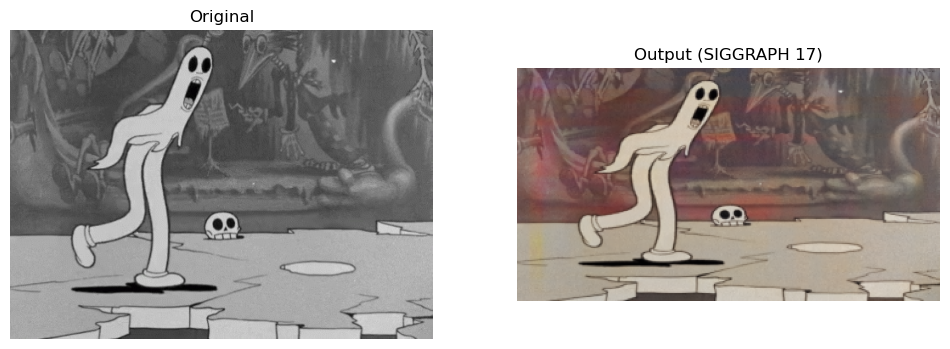

In [65]:
colorizer_eccv16 = eccv16().eval()
colorizer_siggraph17 = siggraph17().eval()

# default size to process images is 256x256
# grab L channel in both original ("orig") and resized ("rs") resolutions
img = load_image(os.path.join(image_bw_path, images[0]))
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))
#if(torch.cuda.is_available()):
#	tens_l_rs = tens_l_rs.cuda()

# colorizer outputs 256x256 ab map
# resize and concatenate to original L channel
#img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
#out_img_eccv16 = postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())
out_img_siggraph17 = postprocess_tens(tens_l_orig, colorizer_siggraph17(tens_l_rs).cpu())
out_img_siggraph17 = out_img_siggraph17*255

out_img_siggraph17 = resize_image(out_img_siggraph17)

#save_image(img_bw, os.path.join(image_col_path, 'bw.jpg'))
#save_image(out_img_eccv16, os.path.join(image_col_path, 'eccv16.jpg'))
save_image(out_img_siggraph17, os.path.join(image_col_path, '00000.jpg'))

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')


plt.subplot(1,2,2)
plt.imshow(out_img_siggraph17/255)
plt.title('Output (SIGGRAPH 17)')
plt.axis('off')
plt.show()

In [70]:
colorize_video(image_bw_path, image_col_path, method, frame_gap=4, use_flow=True)

for image in tqdm(os.listdir(image_col_path)):
    bw_img = load_image(os.path.join(image_bw_path, image))
    col_img = load_image(os.path.join(image_col_path, image))
    col_img = upscale_color(bw_img, col_img)

    save_image(col_img, os.path.join(image_col_path, image)) 

print("Creating Video: ",os.path.join(video_path, video_folder, output_video))

images_2_video(image_col_path, os.path.join(video_path, video_folder, output_video), fps = fps)

Colorizing video with frame gap: 4


100%|██████████| 31/31 [00:00<00:00, 33.34it/s]

Creating Video:  /home/jansp/Documents/Colorization/Examples/ghost_gif/ghost_gif_2_col.avi
